## Loading the graphs
Load the graph as a weighted undirected graph.

In [1]:
import os

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201001")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201001")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201001/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201001/SkipGram_80_20_kg_covid_19_20201001_training_test_epoch_500_delta_0.0001_embedding.npy")
embedding_file = os.path.join(embedding_data_dir, "SkipGram_embedding.npy")

# params
seed = 42
train_percentage = 0.8
patience = 5

In [54]:
chembl_antiviral_smile_cosine_sim_outfile = "chembl_antiviral_smile_and_cosine_sim.tsv"

chembl_antiviral_dir = os.path.join(base_dl_dir, "chembl_antiviral-20201001")

chembl_prefix = 'CHEMBL.COMPOUND'
chembl_nodes_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201001/transformed/ChEMBL/nodes.tsv"
chembl_nodes_file = os.path.join(chembl_antiviral_dir, "nodes.tsv")
chembl_antiviral_file = os.path.join(chembl_antiviral_dir, "sars_cov_2_compounds.txt")

In [77]:
sars_cov_2_gpi_dir = os.path.join(base_dl_dir, "sars-cov-2-gpi")
sars_cov_2_gpi_file = os.path.join(sars_cov_2_gpi_dir, "uniprot_sars-cov-2.gpi")
sars_cov_2_gpi_url = "https://raw.githubusercontent.com/Knowledge-Graph-Hub/kg-covid-19/master/curated/ORFs/uniprot_sars-cov-2.gpi"

In [3]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.3')
assert(get_distribution("embiggen").version == '0.6.0')

#### Download the graph if necessary

In [4]:
import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

#### Download embeddings if necessary

In [6]:
os.makedirs(embedding_data_dir, exist_ok=True)

if not os.path.exists(embedding_file):
    with urllib.request.urlopen(embeddings_url) as response, \
        open(embedding_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

#### Make a sorted edge file if necessary

In [7]:
%%time
from ensmallen_graph import EnsmallenGraph

if not os.path.exists(sorted_edges_file):
    graph = EnsmallenGraph.from_unsorted_csv(
        edge_path = edges_file,
        sources_column="subject",
        destinations_column="object",
        directed=False,
        node_path = nodes_file,
        nodes_column = 'id',
        node_types_column = 'category',
        default_node_type = 'biolink:NamedThing'
    )

    graph.dump_edges(sorted_edges_file,
        sources_column="subject",
        destinations_column="object")

CPU times: user 2min 13s, sys: 6.91 s, total: 2min 20s
Wall time: 2min 22s


In [8]:
%%time
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_sorted_csv(
    edge_path = sorted_edges_file,
    sources_column="subject",
    destinations_column="object",
    directed=False,
    nodes_number=377577,  # should be = or > than actual number
    edges_number=30949369,   # same ^
    node_path = nodes_file,
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

graph.report()

CPU times: user 45.3 s, sys: 2 s, total: 47.3 s
Wall time: 48 s


{'degree_mean': '81.96836406878597',
 'edges_number': '30949369',
 'directed': 'false',
 'singletons': '8314',
 'self_loops_rate': '0.00001554151233261008',
 'density': '0.037284237441157525',
 'self_loops_number': '481',
 'unique_node_types_number': '37',
 'unique_edge_types_number': '0',
 'nodes_number': '377577'}

In [10]:
%%time
pos_training, pos_validation = graph.connected_holdout(train_percentage, seed=seed)

CPU times: user 2min 6s, sys: 2 s, total: 2min 8s
Wall time: 2min 9s


The followings are not strictly necessary, but are offered as sanity checks:

In [13]:
%%time
coherence_check=True
if coherence_check:
    assert graph.contains(pos_training)
    assert graph.contains(pos_validation)
    assert (pos_training | pos_validation).contains(graph)
    assert graph.contains(pos_training | pos_validation)
    assert not pos_training.overlaps(pos_validation)
    assert not pos_validation.overlaps(pos_training)

CPU times: user 19min 47s, sys: 8.17 s, total: 19min 55s
Wall time: 4min 22s


## Loading the embeddings

In [14]:
import numpy as np
embeddings = np.load(embedding_file)

In [22]:
node_curies = list(np.array(pos_training.get_nodes_reverse_mapping()))

In [111]:
assert len(node_curies) == len(embeddings)

### Add the graph nodes representating SARS-CoV-2 as a column (nodes of interest)

In [112]:
sars_cov_2_curie = 'CHEMBL.TARGET:CHEMBL4303835'
sars_cov_2_curie_alt = 'NCBITaxon:2697049'
sars_cov_2_idx = node_curies.index(sars_cov_2_curie)

In [114]:
nodes_of_interest = [
    {'name': 'SARS-CoV-2',
     'curie': sars_cov_2_curie,
     'node_id': node_curies.index(sars_cov_2_curie),
    },
    {'name': 'SARS-CoV-2 (alternate node)',
     'curie': sars_cov_2_curie_alt,
     'node_id': node_curies.index(sars_cov_2_curie_alt),
    },
]

In [115]:
import wget

if not os.path.exists(sars_cov_2_gpi_file):
    os.makedirs(sars_cov_2_gpi_dir, exist_ok=True)
    filename = wget.download(sars_cov_2_gpi_url, sars_cov_2_gpi_file)

with open(sars_cov_2_gpi_file, 'r') as gpi:
    lines = gpi.readlines()
    # print("NAME\tDB ID")
    for line in lines:
        if line.startswith("!"):
            continue
        fields = line.split("\t")
        this_curie = ":".join([fields[0], fields[1]])
        nodes_of_interest.append({'name': fields[2],
                                  'curie': this_curie,
                                  'node_id': node_curies.index(this_curie)
                                 })

### method to compute matrix of cosine similarities

In [144]:
from tqdm import tqdm
from scipy import spatial

def get_cosine_sim(x: list, y: list, embeddings: np.ndarray) ->  np.ndarray:
    cosine_sim = np.full((len(x), len(y)), -1000.0000)

    # precompute node idx to speed things up
    x_node_idx = [node_curies.index(i) for i in tqdm(x, "preloading x node indexes")]
    y_node_idx = [node_curies.index(i) for i in tqdm(y, "preloading y node indexes")]

    for i, row_curie in tqdm(enumerate(x), "computing cosine sim"):
        for j, col_curie in enumerate(y):
            row_emb = embeddings[x_node_idx[i]]
            col_emb = embeddings[y_node_idx[j]]
            cosine_sim[i,j] = 1 - spatial.distance.cosine(row_emb, col_emb)

    return cosine_sim

## Rank ChEMBL antivirals by cosine similarity to SARS-CoV-2

In [ ]:
if not os.path.exists(os.path.join(chembl_nodes_file)):
    os.makedirs(chembl_antiviral_dir, exist_ok=True)
    with urllib.request.urlopen(chembl_nodes_url) as response, \
        open(chembl_nodes_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [ ]:
import re

chembl_antiviral_curies = []
chembl_antiviral_names = []
chembl_antiviral_smile = []

with open(chembl_nodes_file, 'r') as f:
    header = f.readline().split("\t")
    lines = f.readlines()
    for line in lines:
        items = line.split("\t")
        this_id = items[header.index("id")]
        this_name = items[header.index("name")]
        this_smile = items[header.index("canonical_smiles")]
        if re.match(chembl_prefix, this_id):
            chembl_antiviral_curies.append(this_id)
            chembl_antiviral_names.append(this_name)
            chembl_antiviral_smile.append(this_smile)

In [ ]:
chembl_antiviral_cosine_sim = get_cosine_sim(
    chembl_antiviral_curies,
    [i.get("curie") for i in nodes_of_interest],
    embeddings
    )

In [ ]:
# why not
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(chembl_antiviral_cosine_sim, cmap='jet', aspect='auto')
plt.title("Cosine similarity\nChEMBL antivirals vs SARS-CoV-2", fontsize=18)
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90
          )
plt.show()


z = chembl_antiviral_cosine_sim.copy()
z[z < 0] = 0

plt.imshow(z, cmap='jet', aspect='auto')
plt.title("Cosine similarity\nChEMBL antivirals vs SARS-CoV-2\n(remove neg sim)", fontsize=18)
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90)
plt.show()

sars_cov_2_emb = embeddings[sars_cov_2_idx]
sars_cov_2_emb.shape

antiviral_emb = embeddings[chembl_antiviral_idx[0]]
antiviral_emb.shape

In [86]:
if not os.path.exists(os.path.join(chembl_nodes_file)):
    os.makedirs(chembl_antiviral_dir, exist_ok=True)
    with urllib.request.urlopen(chembl_nodes_url) as response, \
        open(chembl_nodes_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [87]:
import re

chembl_antiviral_curies = []
chembl_antiviral_names = []
chembl_antiviral_smile = []

with open(chembl_nodes_file, 'r') as f:
    header = f.readline().split("\t")
    lines = f.readlines()
    for line in lines:
        items = line.split("\t")
        this_id = items[header.index("id")]
        this_name = items[header.index("name")]
        this_smile = items[header.index("canonical_smiles")]
        if re.match(chembl_prefix, this_id):
            chembl_antiviral_curies.append(this_id)
            chembl_antiviral_names.append(this_name)
            chembl_antiviral_smile.append(this_smile)

In [145]:
chembl_antiviral_cosine_sim = get_cosine_sim(
    chembl_antiviral_curies,
    [i.get("curie") for i in nodes_of_interest],
    embeddings
    )

preloading y node indexes: 100%|██████████| 34/34 [00:00<00:00, 206.86it/s]
computing cosine sim: 6900it [00:11, 599.67it/s]


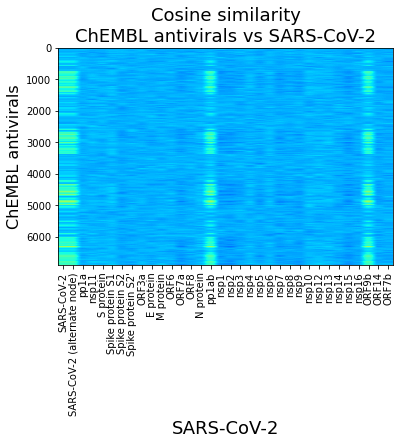

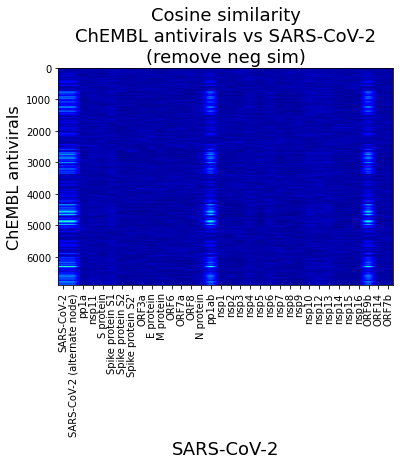

In [146]:
# why not
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(chembl_antiviral_cosine_sim, cmap='jet', aspect='auto')
plt.title("Cosine similarity\nChEMBL antivirals vs SARS-CoV-2", fontsize=18)
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90
          )
plt.show()


z = chembl_antiviral_cosine_sim.copy()
z[z < 0] = 0

plt.imshow(z, cmap='jet', aspect='auto')
plt.title("Cosine similarity\nChEMBL antivirals vs SARS-CoV-2\n(remove neg sim)", fontsize=18)
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90)
plt.show()

In [ ]:
sars_cov_2_emb = embeddings[sars_cov_2_idx]
sars_cov_2_emb.shape

antiviral_emb = embeddings[chembl_antiviral_idx[0]]
antiviral_emb.shape

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

chembl_antiviral_cosine_sim = []

sars_cov_2_emb = embeddings[sars_cov_2_idx]

for antiviral_idx in tqdm(chembl_antiviral_idx):
    antiviral_emb = embeddings[antiviral_idx]
    chembl_antiviral_cosine_sim.append(1 - spatial.distance.cosine(antiviral_emb, sars_cov_2_emb))

In [ ]:
import csv

with open("chembl_antiviral_names_ranked.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(chembl_antiviral_names_ranked)

In [ ]:
chembl_antiviral_names_ranked

In [ ]:
chembl_antiviral_names_ranked[0:10]

In [ ]:
## Rank all drugs by cosine sim to SARS-CoV-2

In [ ]:
assert len(training.node_types) == len(embeddings)

In [ ]:
drug_idx = list(np.where(training.node_types == training.node_types_reverse_mapping.index('biolink:Drug'))[0])

In [ ]:
drug_names = [node_names[i] for i in drug_idx]

In [ ]:
drug_cosine_sim = []

sars_cov_2_emb = embeddings[sars_cov_2_idx]

for drug_i in tqdm(drug_idx):
    drug_emb = embeddings[drug_i]
    drug_cosine_sim.append(1 - spatial.distance.cosine(drug_emb, sars_cov_2_emb))

In [ ]:
drugs_ranked = [[x,y] for y, x in sorted(zip(drug_cosine_sim,drug_names), key=lambda pair: pair[0], reverse=True)]

In [ ]:
drugs_ranked[0:5]

## Sort everything by closeness to SARS-CoV-2



In [ ]:
# Sort all the things
sars_cov_2_emb = embeddings[sars_cov_2_idx]

node_sim = []

for idx in tqdm(range(len(node_names))):
    this_emb = embeddings[idx]
    node_sim.append(1 - spatial.distance.cosine(this_emb, sars_cov_2_emb))

In [ ]:
everything_ranked = [[x,y] for y, x in sorted(zip(node_sim,node_names), key=lambda pair: pair[0], reverse=True)]

In [ ]:
everything_ranked[0:100]